In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from skimage.color import rgb2gray

from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
im_width = 256
im_height = 256

image_filename_train = []

mask_files = glob(pathname='C:/Users/kiran reddy/Downloads/major/archive (9)/kaggle_3m\*\*_mask*')
for i in mask_files:
    image_filename_train.append(i.replace('_mask',''))
print(image_filename_train[:10])
len(image_filename_train)

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']


3929

In [3]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize  = (12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]

        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        print(mask)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


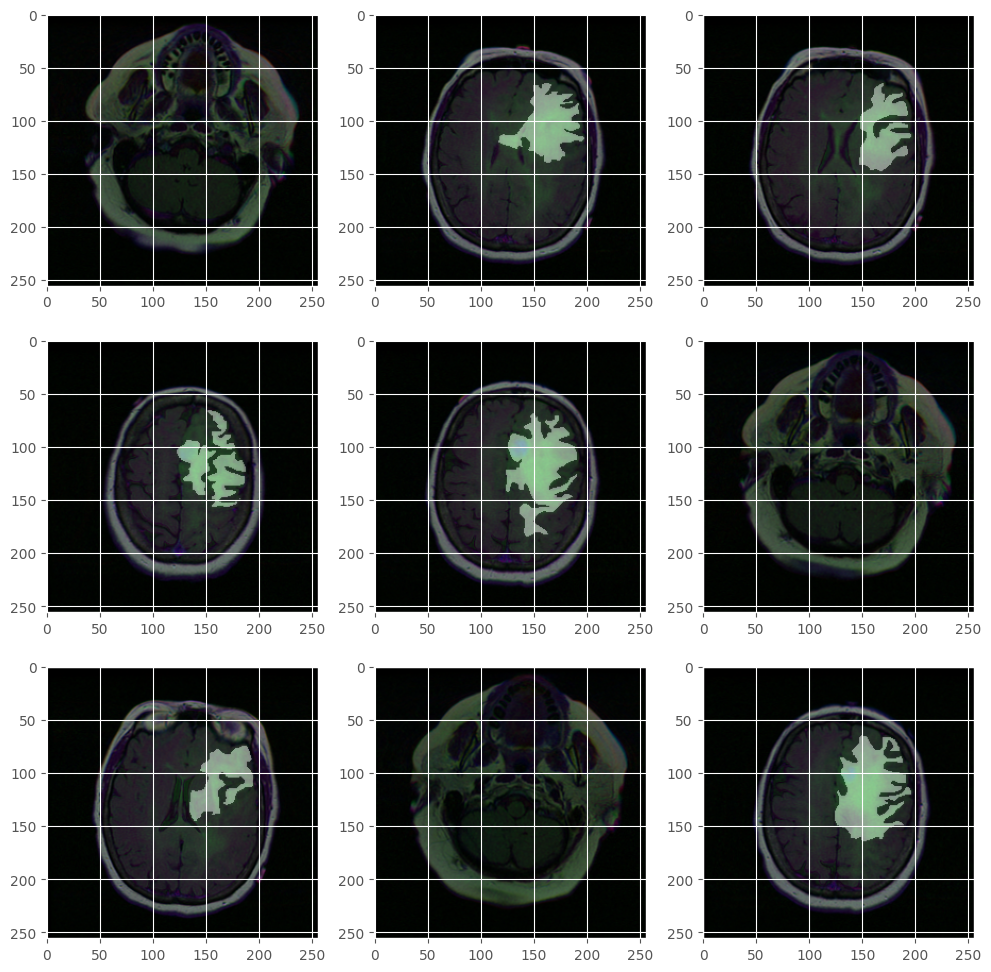

In [4]:
plot_from_img_path(3, 3, image_filename_train, mask_files)

In [5]:
df = pd.DataFrame(data = {'image_filename_train': image_filename_train, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.05)
df_train, df_val = train_test_split(df_train, test_size = 0.05)

In [6]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(3545, 2)
(187, 2)
(197, 2)


In [7]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filename_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [8]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou
def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

In [9]:
# display(Image(filename='U+net_Architecture.png'))


In [10]:
def unet(input_size=(im_width, im_height, 3)):
    
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    # First DownSampling
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    #Second DownSampling
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    # Third DownSampling
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6),conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7),conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8),conv1],axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    

In [12]:

model = unet(input_size=(im_height, im_width, 3))



# decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet_brain_mri_segg.keras', verbose=1, save_best_only=True)]
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE,
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) // BATCH_SIZE)
model.save('unet_brain_mri_seg.h5')

Found 3545 validated image filenames.
Found 3545 validated image filenames.
Epoch 1/100


I0000 00:00:1737895271.031316      70 service.cc:145] XLA service 0x7c27a4002e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737895271.031390      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1737895331.981884      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - binary_accuracy: 0.7914 - dice_coefficients: 0.0674 - iou: 0.0353 - loss: -0.0674Found 187 validated image filenames.
Found 187 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01860, saving model to unet_brain_mri_segg.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 175s 973ms/step - binary_accuracy: 0.7924 - dice_coefficients: 0.0676 - iou: 0.0355 - loss: -0.0676 - val_binary_accuracy: 0.9907 - val_dice_coefficients: 0.0186 - val_iou: 0.0095 - val_loss: -0.0186
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - binary_accuracy: 0.9768 - dice_coefficients: 0.1423 - iou: 0.0774 - loss: -0.1421
Epoch 2: val_loss did not improve from -0.01860
110/110 ━━━━━━━━━━━━━━━━━━━━ 139s 836ms/step - binary_accuracy: 0.9769 - dice_coefficients: 0.1424 - iou: 0.0774 - loss: -0.1422 - val_binary_accuracy: 0.9659 - val_dice_coefficients: 0.0138 - val_iou: 0.0071 - val_loss: -0.0136
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - binary

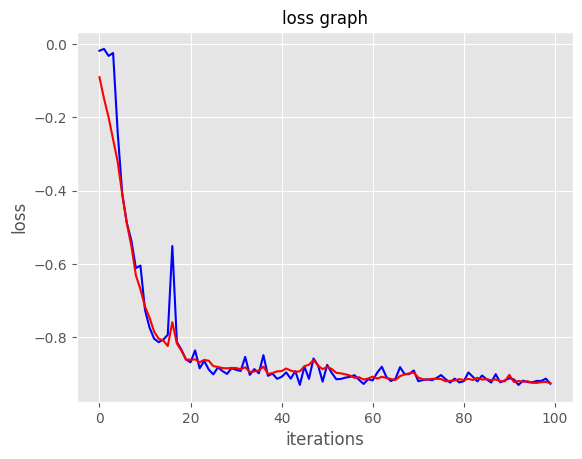

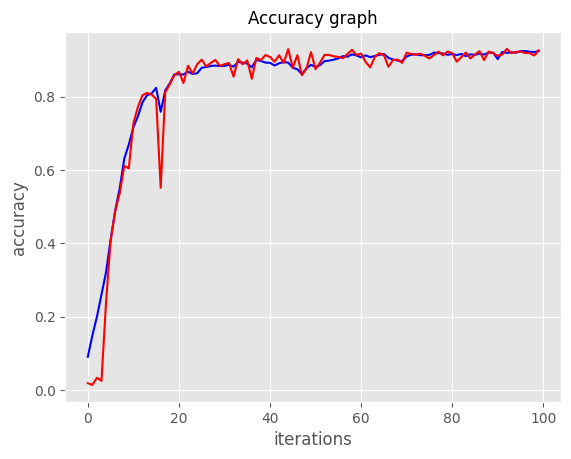

In [19]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

In [21]:

# Load the model after training
model = load_model('/kaggle/working/unet_brain_mri_seg.h5', custom_objects={
    'dice_coefficients_loss': dice_coefficients_loss,
    'iou': iou,
    'dice_coefficients': dice_coefficients
})

In [15]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps = len(df_test)//BATCH_SIZE)
print('Test Loss', results[0])
print('Test IOU', results[1])
print('Test Dice Coeff', results[2])

Found 197 validated image filenames.
Found 197 validated image filenames.
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - binary_accuracy: 0.9983 - dice_coefficients: 0.9060 - iou: 0.8304 - loss: -0.9060
Test Loss -0.8948879837989807
Test IOU 0.9985442757606506
Test Dice Coeff 0.8131787776947021


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


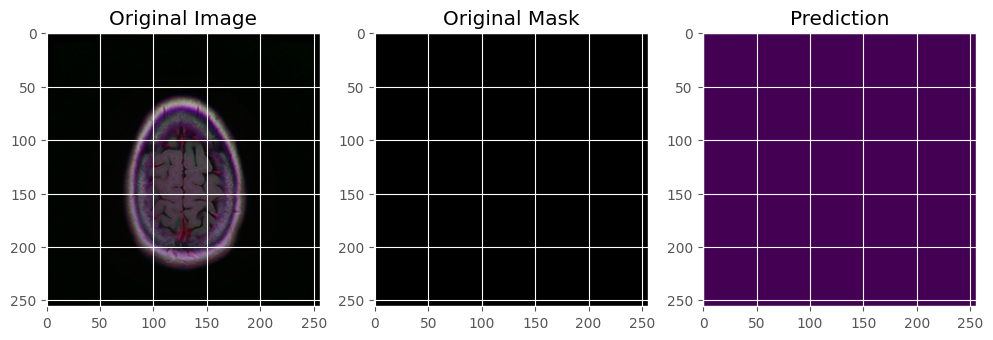

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


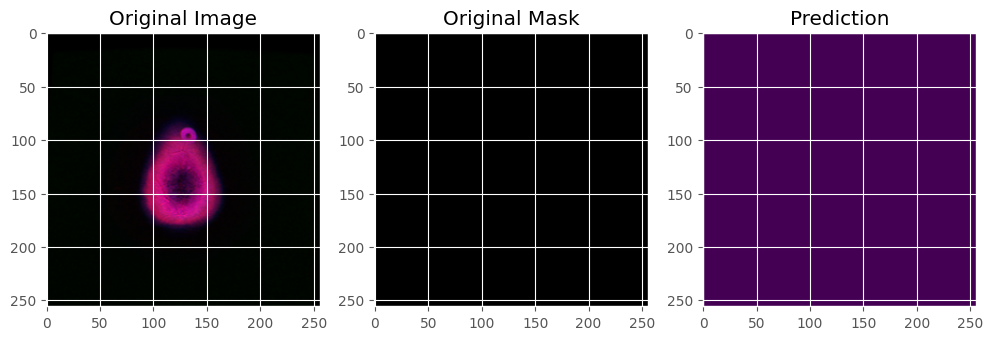

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


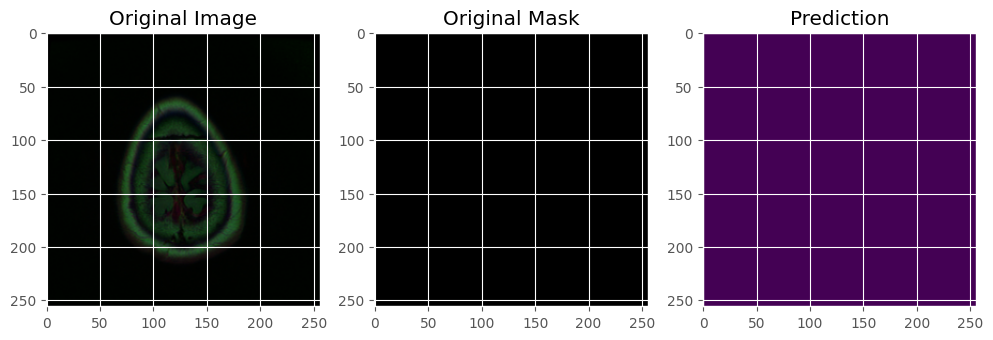

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


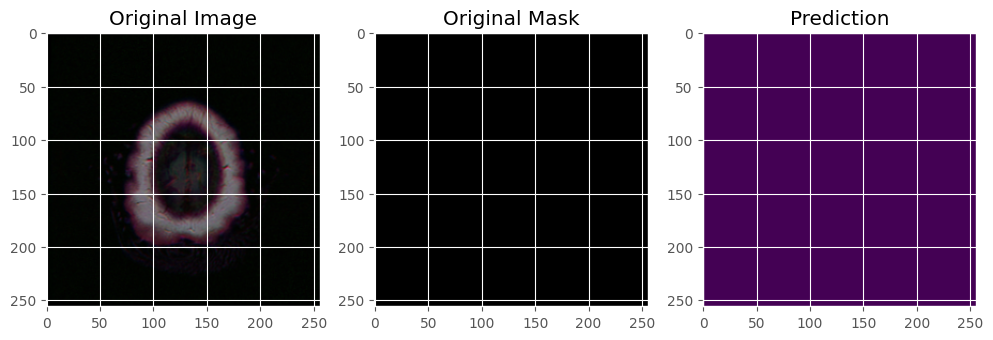

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


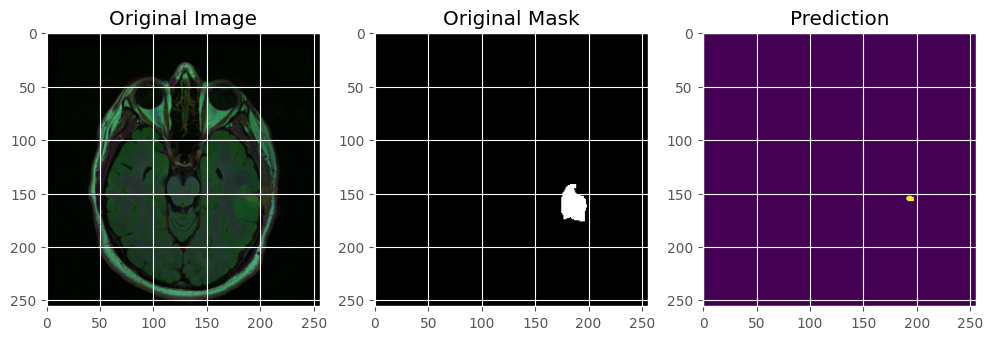

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


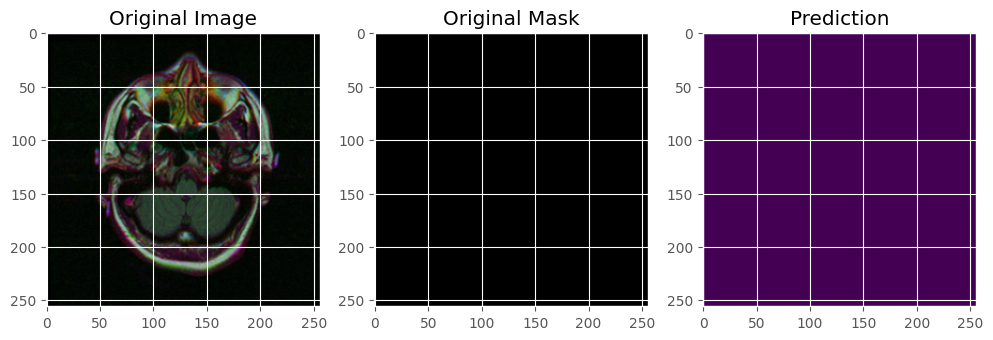

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


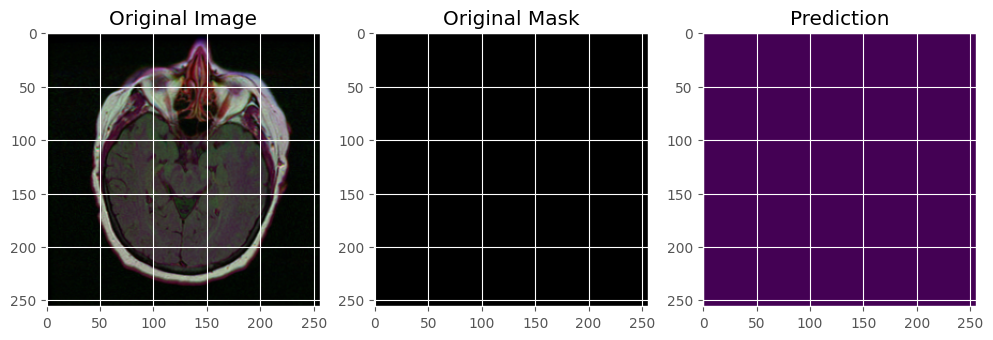

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


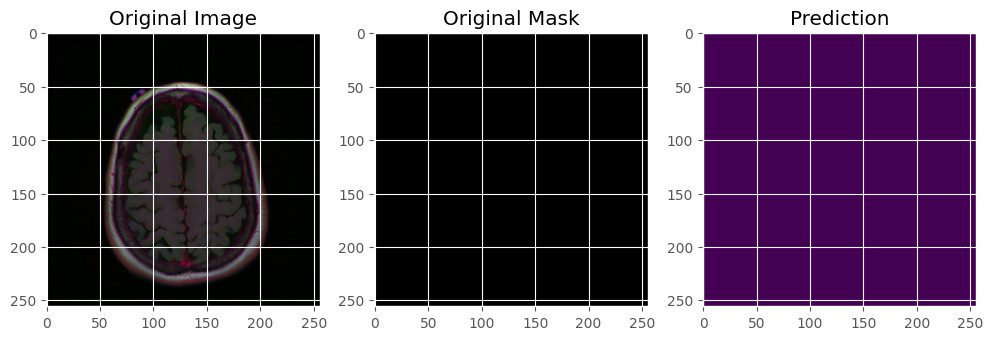

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


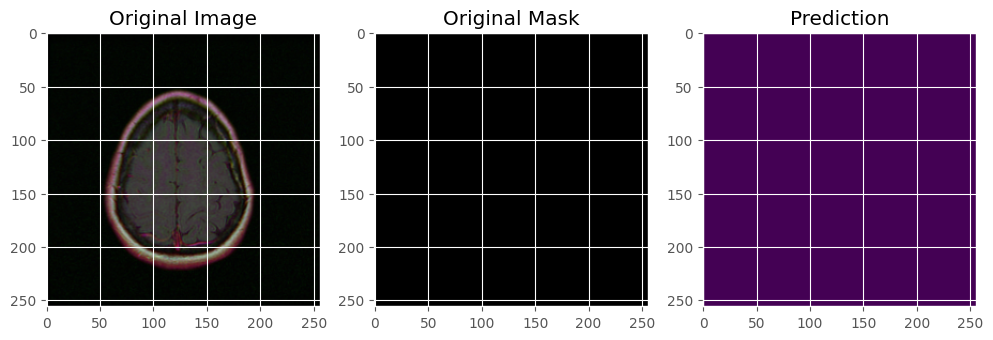

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


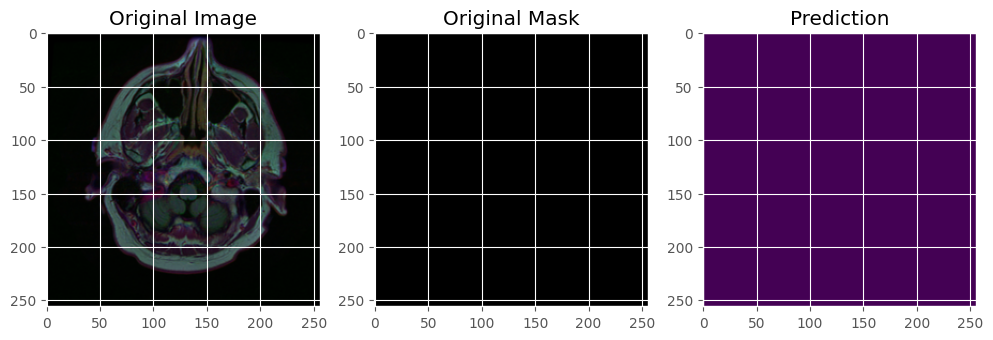

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


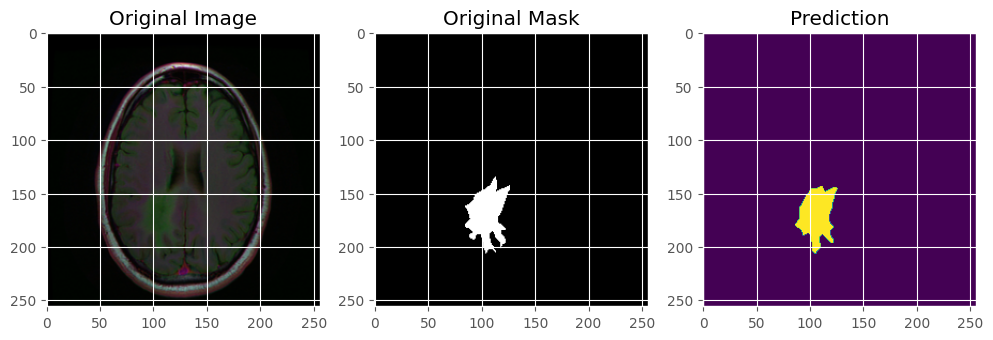

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


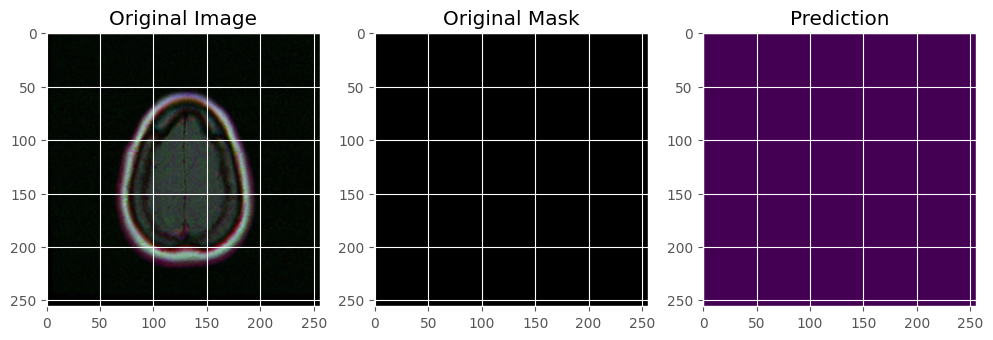

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


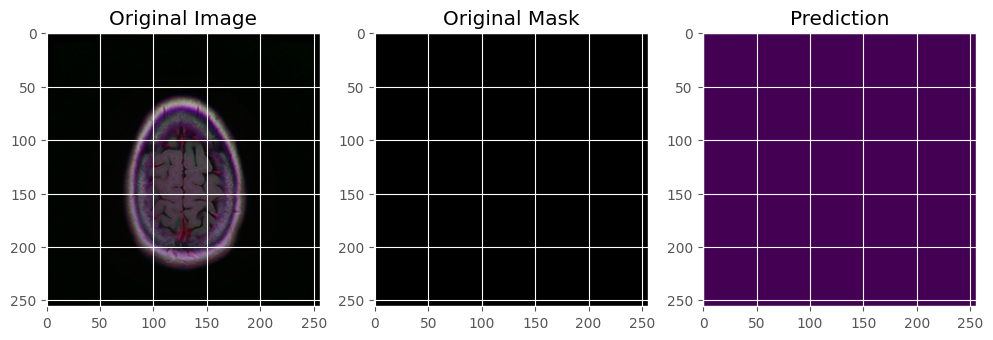

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


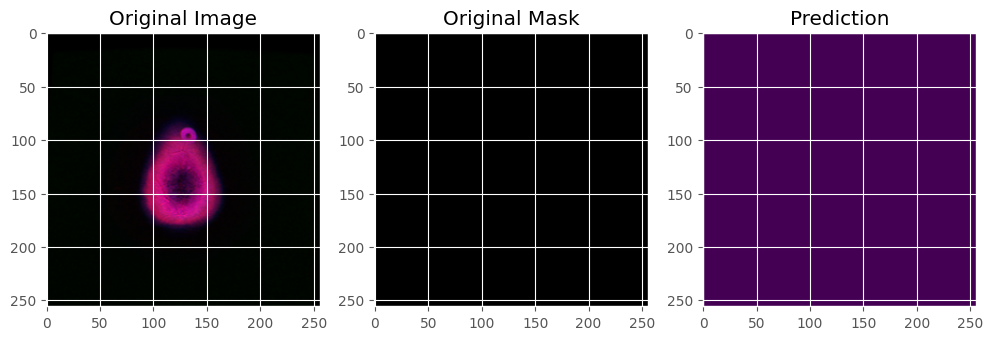

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


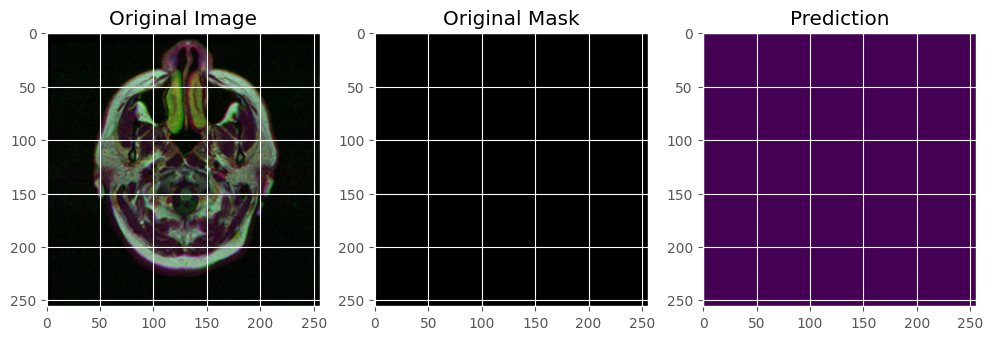

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


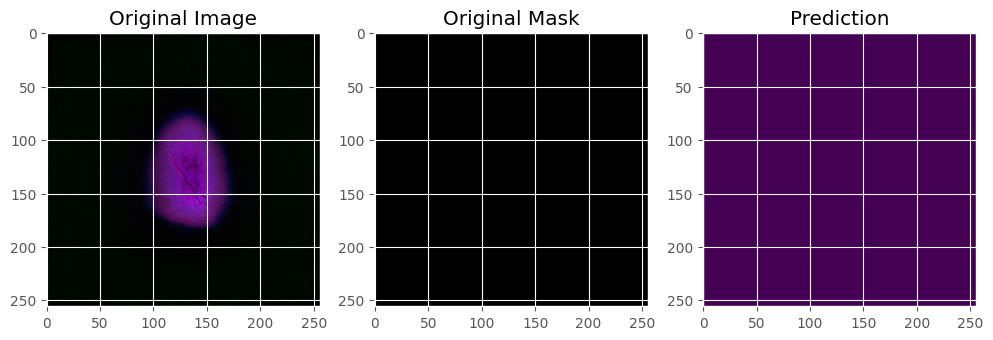

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


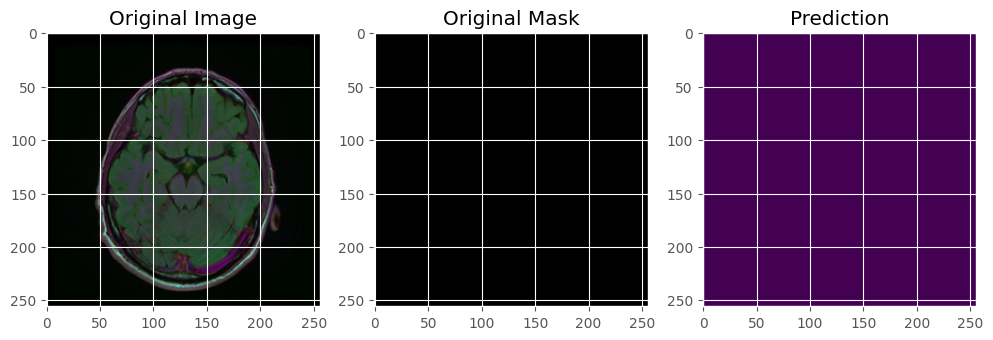

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


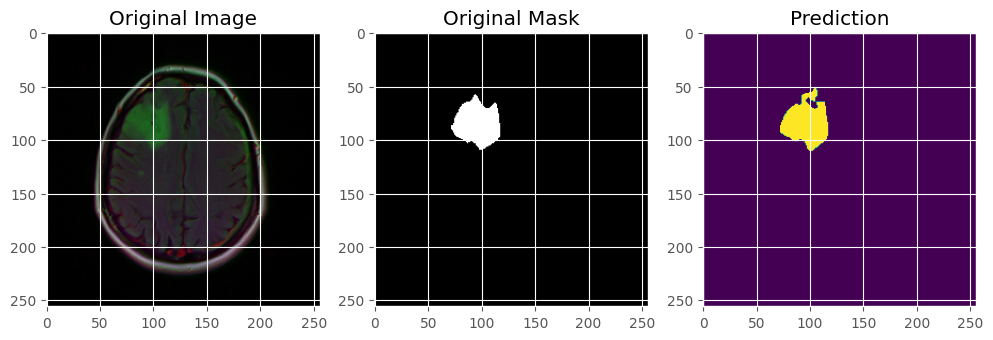

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


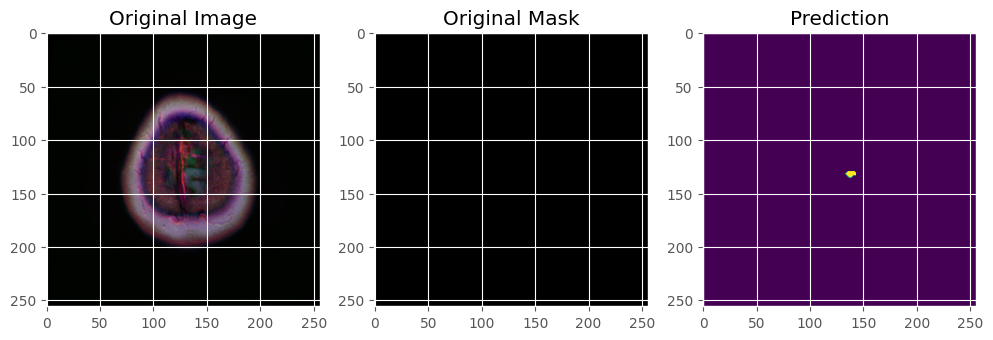

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


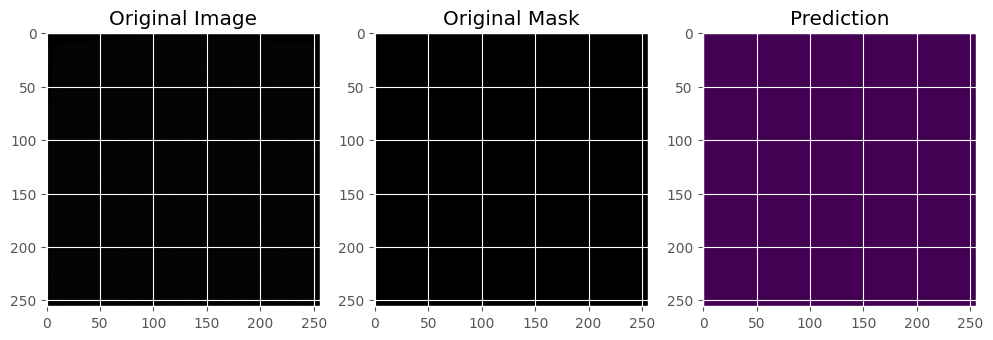

In [16]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5)
    plt.title("Prediction")
    plt.show()

In [17]:
# !pip install streamlit
# import numpy as np
# # import streamlit as st
# import matplotlib.pyplot as plt
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import load_model
# import cv2

# plt.style.use("ggplot")


# def dice_coefficients(y_true, y_pred, smooth=100):
#     y_true_flatten = K.flatten(y_true)
#     y_pred_flatten = K.flatten(y_pred)

#     intersection = K.sum(y_true_flatten * y_pred_flatten)
#     union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
#     return (2 * intersection + smooth) / (union + smooth)


# def dice_coefficients_loss(y_true, y_pred, smooth=100):
#     return -dice_coefficients(y_true, y_pred, smooth)


# def iou(y_true, y_pred, smooth=100):
#     intersection = K.sum(y_true * y_pred)
#     sum = K.sum(y_true + y_pred)
#     iou = (intersection + smooth) / (sum - intersection + smooth)
#     return iou


# def jaccard_distance(y_true, y_pred):
#     y_true_flatten = K.flatten(y_true)
#     y_pred_flatten = K.flatten(y_pred)
#     return -iou(y_true_flatten, y_pred_flatten)


# st.title("Brain MRI Segmentation App")
# model = load_model("/kaggle/working/unet_brain_mri_seg.keras", custom_objects={
#         'dice_coef_loss': dice_coefficients_loss, 'iou': iou, 'dice_coef': dice_coefficients})

# im_height = 256
# im_width = 256

# file = st.file_uploader("Upload file", type=[
#                             "csv", "png", "jpg"], accept_multiple_files=True)
# if file:
#     for i in file:
#         st.header("Original Image:")
#         st.image(i)
#         content = i.getvalue()
#         image = np.asarray(bytearray(content), dtype="uint8")
#         image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#         img2 = cv2.resize(image, (im_height, im_width))
#         img3 = img2/255
#         img4 = img3[np.newaxis, :, :, :]
#         if st.button("Predict Output:"):
#             pred_img = model.predict(img4)
#             st.header("Predicted Image:")
#             st.image(pred_img)
#         else:
#             continue

In [18]:
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import cv2

plt.style.use("ggplot")


def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)


def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)


def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou


def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)


st.title("Brain MRI Segmentation App")
model = load_model("/kaggle/working/unet_brain_mri_seg.h5", custom_objects={
        'dice_coef_loss': dice_coefficients_loss, 'iou': iou, 'dice_coef': dice_coefficients})

im_height = 256
im_width = 256

file = st.file_uploader("Upload file", type=[
                            "csv", "png", "jpg"], accept_multiple_files=True)
if file:
    for i in file:
        st.header("Original Image:")
        st.image(i)
        content = i.getvalue()
        image = np.asarray(bytearray(content), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        img2 = cv2.resize(image, (im_height, im_width))
        img3 = img2/255
        img4 = img3[np.newaxis, :, :, :]
        if st.button("Predict Output:"):
            pred_img = model.predict(img4)
            st.header("Predicted Image:")
            st.image(pred_img)
        else:
            continue

ModuleNotFoundError: No module named 'streamlit'